In [114]:
import librosa as lb
import os
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

from glob import glob
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, Nadam
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPool1D, Flatten, LSTM, MaxPool2D, ConvLSTM2D
from librosa import load
from librosa.feature import mfcc
from sklearn.model_selection import train_test_split

In [65]:
DEFAULT_BITRATE = 22050
DESIRED_DURATION = 25
PADDED_LENGTH = DEFAULT_BITRATE * DESIRED_DURATION
NUM_MFCCS = 32

In [66]:
def load_audio(folder):
    # load original mp3s
    loaded_mp3_files = [load(f) for f in glob(folder + '*.mp3')[:40]]
    
    # make same length
    fix_length_mp3 = normalize_audio(loaded_mp3_files)
    
    mfccs = [mfcc(y=y, sr=DEFAULT_BITRATE, n_mfcc=NUM_MFCCS) for y in fix_length_mp3]
    return mfccs

In [67]:
def normalize_audio(source_files):
    fixed_lengths = [lb.util.fix_length(y, PADDED_LENGTH) for y, _ in source_files]
    return [(f - np.mean(f)) / np.std(f) for f in fixed_lengths]

In [68]:
def flatten_input(input):
    return np.array([x.reshape(x.shape[0] * x.shape[1]) for x in input])

In [81]:
us_X = load_audio('../data/speech-accent-archive/recordings/usa/')
uk_X = load_audio('../data/speech-accent-archive/recordings/uk/')
hk_X = load_audio('../data/speech-accent-archive/recordings/hongkong/')
cn_X = load_audio('../data/speech-accent-archive/recordings/china/')
ger_X = load_audio('../data/speech-accent-archive/recordings/germany/')

In [82]:
us_X[0].shape
# flattened_us_X = flatten_input(us_X)
# flattened_uk_X = flatten_input(uk_X)
# flattened_hk_X = flatten_input(hk_X)
# flattened_cn_X = flatten_input(cn_X)
# flattened_ger_X = flatten_input(ger_X)

(32, 1077)

In [83]:
X = np.concatenate([us_X, uk_X, hk_X, cn_X, ger_X])
Y = np.zeros(len(us_X) + len(uk_X) + len(hk_X) + len(cn_X) + len(ger_X))
Y[21:40] = 1
Y[41:60] = 2
Y[61:80] = 3
Y[81:100] = 4

In [84]:
Y_categorical = to_categorical(Y)
print(X.shape)
print(Y_categorical.shape)

(175, 32, 1077)
(175, 5)


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_categorical, test_size=0.2, random_state=420)

In [86]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(140, 32, 1077)
(140, 5)
(35, 32, 1077)
(35, 5)


In [79]:
def ff_model(X_train, y_train, X_test, y_test):
    X_val = X_train[:15]
    y_val = y_train[:15]
    X_train_true = X_train[15:]
    y_train_true = y_train[15:]
    
    model = Sequential()
    model.add(Dense(2048, activation='relu', input_shape=(34464,)))
    model.add(Dropout(0.3))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x=X_train_true, y=y_train_true, epochs=16, validation_data=(X_val, y_val),
             callbacks=[EarlyStopping(monitor='val_loss', patience=2)], shuffle=True)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test loss: %s' % loss)
    print('Test accuracy: %s' % accuracy)
    
    return model, history

In [80]:
ffmodel, ffhistory = ff_model(X_train, y_train, X_test, y_test)

Train on 125 samples, validate on 15 samples
Epoch 1/16
125/125 [==============================] - 22s 175ms/step - loss: 7.7894 - acc: 0.5120 - val_loss: 8.5963 - val_acc: 0.4667
Epoch 2/16
125/125 [==============================] - 10s 83ms/step - loss: 6.5776 - acc: 0.5920 - val_loss: 8.5963 - val_acc: 0.4667
Epoch 3/16
35/35 [==============================] - 1s 16ms/step
Test loss: 7.82878938402
Test accuracy: 0.514285715137


In [87]:
def plot_train_val_acc(history):
    # Plot train-val accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

In [88]:
def plot_train_val_loss(history):
    # Plot tran-val loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

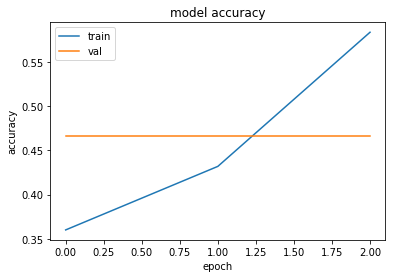

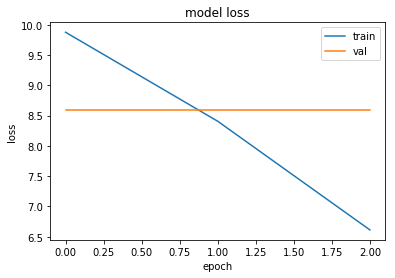

In [57]:
plot_train_val_acc(ffhistory)
plot_train_val_loss(ffhistory)

In [120]:
def cnn_model(X_train, y_train, X_test, y_test):
    X_val = X_train[:15]
    y_val = y_train[:15]
    X_train_true = X_train[15:]
    y_train_true = y_train[15:]
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 1077, 1)))
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(x=X_train_true, y=y_train_true, epochs=16, validation_data=(X_val, y_val), 
              callbacks=[EarlyStopping(monitor='val_loss', patience=2)], shuffle=True)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test loss: %s' % loss)
    print('Test accuracy: %s' % accuracy)
    
    return model

In [121]:
X_train.shape

(140, 32, 1077)

In [122]:
cnn_model = cnn_model(X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1), 
                      y_train, 
                      X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1), 
                      y_test)

Train on 125 samples, validate on 15 samples
Epoch 1/16
125/125 [==============================] - 19s 152ms/step - loss: 8.2502 - acc: 0.3840 - val_loss: 8.5963 - val_acc: 0.4667
Epoch 2/16
125/125 [==============================] - 13s 108ms/step - loss: 6.5762 - acc: 0.5920 - val_loss: 8.5963 - val_acc: 0.4667
Epoch 3/16
35/35 [==============================] - 1s 30ms/step
Test loss: 7.82878938402
Test accuracy: 0.514285715137


In [ ]:
def rnn_model(X_train, y_train, X_test, y_test):
    X_val = X_train[:15]
    y_val = y_train[:15]
    X_train_true = X_train[15:]
    y_train_true = y_train[15:]
    
    model = Sequential()
    model.add(LSTM(16, input_shape=(68928, 1)))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(x=X_train_true, y=y_train_true, epochs=16, validation_data=(X_val, y_val))
    
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test loss: %s' % loss)
    print('Test accuracy: %s' % accuracy)
    
    return model

In [63]:
rnnmodel = rnn_model(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), 
                      y_train, 
                      X_test.reshape(X_test.shape[0], X_test.shape[1], 1), 
                      y_test)

Train on 125 samples, validate on 15 samples
Epoch 1/16
125/125 [==============================] - 261s 2s/step - loss: 1.6473 - acc: 0.3200 - val_loss: 1.5868 - val_acc: 0.4000
Epoch 2/16
125/125 [==============================] - 247s 2s/step - loss: 1.6194 - acc: 0.3760 - val_loss: 1.5751 - val_acc: 0.4000
Epoch 3/16


KeyboardInterrupt: 